In [17]:
#load in packages
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import warnings
dpdcalls = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefilelatlong/dpdshapefilelatlong.shp')
dpdcalls = dpdcalls.loc[~(dpdcalls["X"] == 0) & ~(dpdcalls["Y"] == 0)].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(twotosix)].copy()
dpdcalls
pd.set_option("display.max_columns", 100,"display.max_rows",100)

In [86]:
callsperaddress = dpdcalls.groupby( ["Address"] ).size().to_frame(name = 'dpdcalls_count').reset_index()
callsperaddress.sort_values(by='dpdcalls_count', inplace=True, ascending=False)
callsperaddress

,Address,dpdcalls_count
3679,200 S MANGUM ST,892
5779,3400 HILLSBOROUGH RD,826
5967,3600 N ROXBORO ST,808
7619,5400 NEW HOPE COMMONS DR,608
8173,6900 FAYETTEVILLE RD,585
...,...,...
6921,4700 DENFIELD ST,1
6920,4700 DANUBE LN,1
6917,4700 CORAL DR,1
6916,4700 CHICOPEE TRL,1


In [2]:
ncblockmap = gpd.read_file('/Users/erikrobertsson/Downloads/Northcarolinablocksshapefiles/tl_2021_37_tabblock20.shp')
ncblockmap = ncblockmap.to_crs("EPSG:4326")
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [6]:
policebeats = gpd.read_file('/Users/erikrobertsson/Desktop/Police_Beats/Police_Beats.shp')
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["Beat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats.head()

,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,Beat,id
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2
3,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3
4,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4


In [15]:
hispanicdata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanic data/hispanicdata.csv', skiprows =1)
hispanicdata['GEOID20'] = hispanicdata['id'].str[-15:]
hispanicdata.drop('id', axis=1, inplace=True)
hispanicdata.drop(hispanicdata.iloc[:, 4:74], inplace = True, axis = 1)
hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[#,@,&,!]', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[:]', '_')
hispanicdata.rename(columns = {'total_':'total', 'total_not_hispanic_or_latino_':'total_not_hispanic_or_latino'}, inplace = True)
hispanicdata

,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,geoid20
0,"Block 1000, Block Group 1, Census Tract 1.01, ...",108,25,83,370630001011000
1,"Block 1001, Block Group 1, Census Tract 1.01, ...",35,12,23,370630001011001
2,"Block 1002, Block Group 1, Census Tract 1.01, ...",38,8,30,370630001011002
3,"Block 1003, Block Group 1, Census Tract 1.01, ...",43,0,43,370630001011003
4,"Block 1004, Block Group 1, Census Tract 1.01, ...",31,7,24,370630001011004
...,...,...,...,...,...
4396,"Block 1068, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001068
4397,"Block 1069, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001069
4398,"Block 1070, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001070
4399,"Block 1071, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001071


In [18]:
ncblockmap = gpd.read_file('/Users/erikrobertsson/Downloads/Northcarolinablocksshapefiles/tl_2021_37_tabblock20.shp')
ncblockmap = ncblockmap.to_crs("EPSG:4326")
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,geoid20,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,"Block 1000, Block Group 1, Census Tract 1.01, ...",108,25,83,370630001011000,37,063,000101,1000,370630001011000,Block 1000,G5040,R,None,None,S,655575,0,+36.0194814,-078.8821382,"POLYGON ((-78.88998 36.01852, -78.88995 36.019..."
1,"Block 1001, Block Group 1, Census Tract 1.01, ...",35,12,23,370630001011001,37,063,000101,1001,370630001011001,Block 1001,G5040,R,None,None,S,23209,0,+36.0205516,-078.8893121,"POLYGON ((-78.88993 36.02006, -78.88990 36.021..."
2,"Block 1002, Block Group 1, Census Tract 1.01, ...",38,8,30,370630001011002,37,063,000101,1002,370630001011002,Block 1002,G5040,R,None,None,S,17466,0,+36.0205916,-078.8869754,"POLYGON ((-78.88749 36.02015, -78.88746 36.021..."
3,"Block 1003, Block Group 1, Census Tract 1.01, ...",43,0,43,370630001011003,37,063,000101,1003,370630001011003,Block 1003,G5040,R,None,None,S,22809,0,+36.0205318,-078.8880959,"POLYGON ((-78.88872 36.01988, -78.88867 36.021..."
4,"Block 1004, Block Group 1, Census Tract 1.01, ...",31,7,24,370630001011004,37,063,000101,1004,370630001011004,Block 1004,G5040,R,None,None,S,21727,0,+36.0221289,-078.8796703,"POLYGON ((-78.88098 36.02211, -78.87992 36.022..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,"Block 1068, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001068,37,063,980100,1068,370639801001068,Block 1068,G5040,R,None,None,S,19590,0,+35.8697575,-078.8648679,"POLYGON ((-78.86527 35.87075, -78.86498 35.870..."
4397,"Block 1069, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001069,37,063,980100,1069,370639801001069,Block 1069,G5040,R,None,None,S,8413,0,+35.8691012,-078.8652956,"POLYGON ((-78.86568 35.87061, -78.86540 35.870..."
4398,"Block 1070, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001070,37,063,980100,1070,370639801001070,Block 1070,G5040,R,None,None,S,104861,0,+35.8687255,-078.8673419,"POLYGON ((-78.87003 35.86799, -78.86977 35.868..."
4399,"Block 1071, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001071,37,063,980100,1071,370639801001071,Block 1071,G5040,R,None,None,S,59161,0,+35.8957583,-078.8703320,"POLYGON ((-78.87243 35.89600, -78.87216 35.896..."


In [24]:
durhamhispanicmap = pd.merge(hispanicdata, durhamblockmap, left_on ='geoid20', right_on='GEOID20')
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'geoid20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap

,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,COUNTYFP20,GEOID20,INTPTLAT20,INTPTLON20,geometry
0,"Block 1000, Block Group 1, Census Tract 1.01, ...",108,25,83,063,370630001011000,+36.0194814,-078.8821382,"POLYGON ((-78.88998 36.01852, -78.88995 36.019..."
1,"Block 1001, Block Group 1, Census Tract 1.01, ...",35,12,23,063,370630001011001,+36.0205516,-078.8893121,"POLYGON ((-78.88993 36.02006, -78.88990 36.021..."
2,"Block 1002, Block Group 1, Census Tract 1.01, ...",38,8,30,063,370630001011002,+36.0205916,-078.8869754,"POLYGON ((-78.88749 36.02015, -78.88746 36.021..."
3,"Block 1003, Block Group 1, Census Tract 1.01, ...",43,0,43,063,370630001011003,+36.0205318,-078.8880959,"POLYGON ((-78.88872 36.01988, -78.88867 36.021..."
4,"Block 1004, Block Group 1, Census Tract 1.01, ...",31,7,24,063,370630001011004,+36.0221289,-078.8796703,"POLYGON ((-78.88098 36.02211, -78.87992 36.022..."
...,...,...,...,...,...,...,...,...,...
4396,"Block 1068, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001068,+35.8697575,-078.8648679,"POLYGON ((-78.86527 35.87075, -78.86498 35.870..."
4397,"Block 1069, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001069,+35.8691012,-078.8652956,"POLYGON ((-78.86568 35.87061, -78.86540 35.870..."
4398,"Block 1070, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001070,+35.8687255,-078.8673419,"POLYGON ((-78.87003 35.86799, -78.86977 35.868..."
4399,"Block 1071, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001071,+35.8957583,-078.8703320,"POLYGON ((-78.87243 35.89600, -78.87216 35.896..."


In [ ]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

In [35]:
cblockcommsafebeats = cblockDurhamBeats.copy()
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
cblockcommsafebeats = cblockDurhamBeats.loc[cblockDurhamBeats['Beat'].isin(commsafe_list)].copy()
cblockcommsafebeats

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,Beat
874,37,063,001709,3001,370630017093001,Block 3001,G5040,R,None,None,S,918860,1497,+36.0511955,-078.8989718,"POLYGON ((-78.90312 36.05133, -78.90293 36.051...",223
3649,37,063,001801,6041,370630018016041,Block 6041,G5040,R,None,None,S,212123,9487,+36.0155379,-078.8706505,"POLYGON ((-78.87550 36.01421, -78.87371 36.014...",214
10944,37,063,000101,1028,370630001011028,Block 1028,G5040,R,None,None,S,435000,2847,+36.0161756,-078.8795383,"POLYGON ((-78.88806 36.01514, -78.88789 36.015...",214
11876,37,063,001801,6033,370630018016033,Block 6033,G5040,R,None,None,S,131608,6435,+36.0263370,-078.8611270,"POLYGON ((-78.86503 36.02664, -78.86499 36.026...",214
12204,37,063,001801,7005,370630018017005,Block 7005,G5040,R,None,None,S,11498,1223,+36.0602307,-078.8586903,"POLYGON ((-78.85984 36.06053, -78.85928 36.060...",214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235109,37,063,002200,2031,370630022002031,Block 2031,G5040,R,None,None,S,14546,0,+35.9983414,-078.8990835,"POLYGON ((-78.89993 35.99915, -78.89960 35.998...",512
235830,37,063,002300,1027,370630023001027,Block 1027,G5040,R,None,None,S,57219,0,+35.9854948,-078.9077482,"POLYGON ((-78.90906 35.98449, -78.90900 35.984...",411
236139,37,063,002200,2048,370630022002048,Block 2048,G5040,R,None,None,S,10849,0,+35.9949422,-078.8981501,"POLYGON ((-78.89882 35.99520, -78.89875 35.995...",512
236183,37,063,002200,1012,370630022001012,Block 1012,G5040,R,None,None,S,11653,0,+36.0007075,-078.9093748,"POLYGON ((-78.90950 36.00137, -78.90934 36.001...",511


In [30]:
durhamhispanicmap = durhamblockmap.set_index('GEOID20').join(hispanicdata.set_index('geoid20'))
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap.head(3)

,COUNTYFP20,INTPTLAT20,INTPTLON20,geometry,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,prophispanic
GEOID20,,,,,,,,,
370630018064007,063,+36.0127651,-078.8227713,"POLYGON ((-78.82464 36.01317, -78.82456 36.013...","Block 4007, Block Group 4, Census Tract 18.06,...",80,33,47,0.4125
370630018017028,063,+36.0696478,-078.7923950,"POLYGON ((-78.80507 36.06321, -78.80467 36.063...","Block 7028, Block Group 7, Census Tract 18.01,...",0,0,0,NaN
370630021004022,063,+36.1529771,-078.8218382,"POLYGON ((-78.83005 36.15072, -78.83001 36.150...","Block 4022, Block Group 4, Census Tract 21, Du...",88,0,88,0.0000


In [36]:
blockswithhispanics = gpd.sjoin(durhamhispanicmap, cblockcommsafebeats)
blockswithhispanics['prophispanic']= blockswithhispanics['total_hispanic_or_latino'] / blockswithhispanics['total']
blockswithhispanics.head(3)

,COUNTYFP20_left,INTPTLAT20_left,INTPTLON20_left,geometry,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,prophispanic,index_right,STATEFP20,COUNTYFP20_right,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20_right,INTPTLON20_right,Beat
GEOID20,,,,,,,,,,,,,,,,,,,,,,,,,,
370630018017041,063,+36.0558254,-078.8296616,"POLYGON ((-78.83393 36.05431, -78.83343 36.055...","Block 7041, Block Group 7, Census Tract 18.01,...",9,3,6,0.333333,225453,37,063,001801,6008,370630018016008,Block 6008,G5040,R,None,None,S,100889,0,+36.0519717,-078.8336224,214
370630018016014,063,+36.0496473,-078.8467110,"POLYGON ((-78.85571 36.04408, -78.85557 36.044...","Block 6014, Block Group 6, Census Tract 18.01,...",195,79,116,0.405128,225453,37,063,001801,6008,370630018016008,Block 6008,G5040,R,None,None,S,100889,0,+36.0519717,-078.8336224,214
370630018016009,063,+36.0426464,-078.8352676,"POLYGON ((-78.84667 36.03546, -78.84547 36.037...","Block 6009, Block Group 6, Census Tract 18.01,...",97,27,70,0.278351,225453,37,063,001801,6008,370630018016008,Block 6008,G5040,R,None,None,S,100889,0,+36.0519717,-078.8336224,214


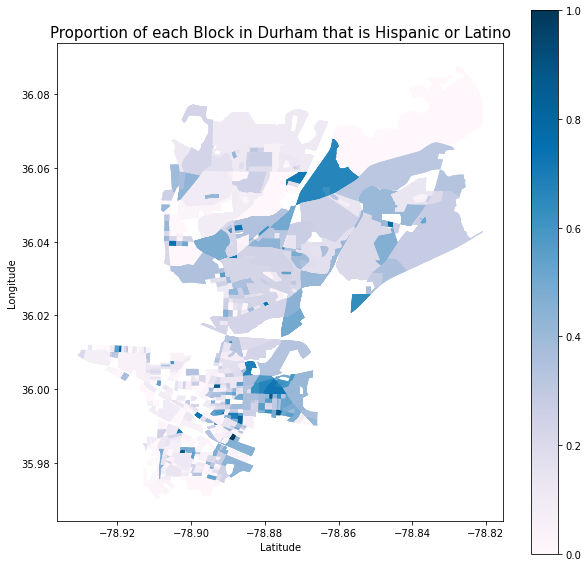

In [44]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
blockswithhispanics.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of each Block in Durham that is Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [40]:
#putting race data into the police beat and block data
beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
hispanicsineachbeat = pd.merge(popsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
hispanicsineachbeat = hispanicsineachbeat.to_crs("EPSG:4326")
hispanicsineachbeat['prophispanic']= hispanicsineachbeat['total_hispanic_or_latino'] / hispanicsineachbeat['total']

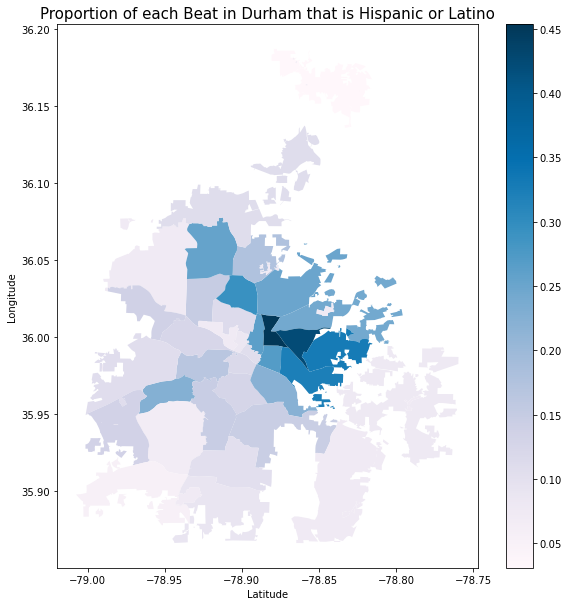

In [41]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
hispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of each Beat in Durham that is Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [42]:
commsafebeatswithhispanics = gpd.sjoin(cblockcommsafebeats, durhamhispanicmap)
commsafepopsumbybeat = commsafebeatswithhispanics.groupby('Beat', as_index=False).sum()
commsafehispanicsineachbeat = pd.merge(commsafepopsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
commsafehispanicsineachbeat = commsafehispanicsineachbeat.to_crs("EPSG:4326")
commsafehispanicsineachbeat['prophispanic']= commsafehispanicsineachbeat['total_hispanic_or_latino'] / commsafehispanicsineachbeat['total']

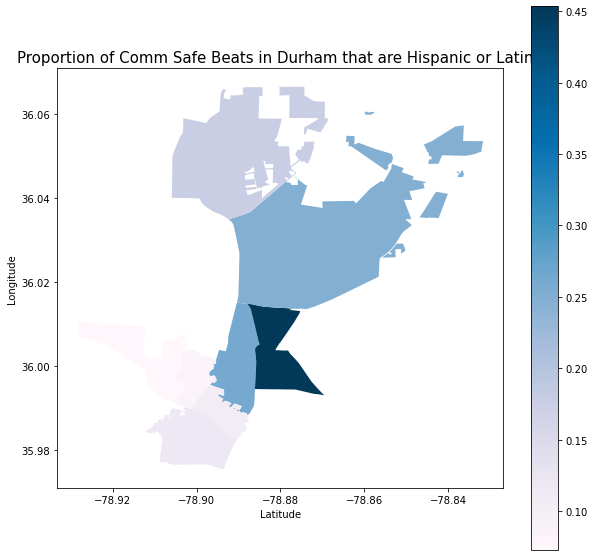

In [43]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Comm Safe Beats in Durham that are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

commsafehispanicsineachbeat = hispanics by police beat but only including the beats that the community safety department is currently working in
hispanicsineachbeat = hispanics by police beat for all police beats in durham
blockswithhispanics = hispanics by census block but only the blocks in beats that the community safety department is currently working in

In [67]:
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
hispanicsinnoncommsafebeat = hispanicsineachbeat[~hispanicsineachbeat.Beat_x.isin(commsafe_list)]
hispanicsinnoncommsafebeat.head()

,Beat_x,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,prophispanic,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,Beat_y,id
2,113,20482283,13325,35128,9451,25677,0.269045,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2
3,114,56673958,441791,53897,17371,36526,0.322300,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3
4,121,154087358,1453287,66559,16154,50405,0.242702,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4
5,122,34177498,14796,42111,17801,24310,0.422716,122,"POLYGON ((-78.84694 36.00614, -78.84634 36.006...",54,36686.679688,I,yes,D1,122,None,3.436298e+07,36686.681354,122,5
6,123,102491731,1285915,92956,30606,62350,0.329253,123,"MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...",55,74375.859375,I,yes,D1,123,None,7.495698e+07,74375.856455,123,6


In [69]:
meanpropofhispanicsnotincommsafe = hispanicsinnoncommsafebeat[["prophispanic"]].mean()
meanpropofhispanicsnotincommsafe

prophispanic    0.16163
dtype: float64

In [46]:
meanpropofhispanicsincommsafe = commsafehispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsincommsafe

prophispanic    0.190683
dtype: float64

In [47]:
meanpropofhispanicsinallbeats = hispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsinallbeats

prophispanic    0.167912
dtype: float64